# Confidence Intervals

In [1]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2

import warnings

warnings.simplefilter("ignore")

import os
import sys
import numpy as np

from itertools import product
from cycler import cycler
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("seaborn-colorblind")
PLT_COLOR = plt.rcParams["axes.prop_cycle"].by_key()["color"]
PLT_LINES = ["-", "--", ":", "-."]
PLT_CYCLER = cycler(color=PLT_COLOR * 2) + cycler(linestyle=PLT_LINES * 3)

import pandas as pd

pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)
pd.plotting.register_matplotlib_converters()


import logging

logging.basicConfig(level=logging.INFO, stream=sys.stdout)

In [2]:
import scipy
from functools import partial
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor

from xgboost.sklearn import XGBRegressor

In [3]:
np.random.seed(1)

# Parameters

In [4]:
ALPHA = 0.95
QUANTILES = [1 - ALPHA, 0.5, ALPHA]

# Functions

In [5]:
def plot_result_toax(ax, alpha, preds, X_train, y_train, X_test, y_test):

    assert len(preds) == 3, "Predicitons require 3 entries"
    y_lower, y_pred, y_upper = preds

    fill_color = PLT_COLOR[0]

    ax.fill(
        np.concatenate([X_test, X_test[::-1]]),
        np.concatenate([y_upper, y_lower[::-1]]),
        alpha=0.2,
        fc=fill_color,
        ec="none",
        label="{:.0%} prediction interval".format(alpha),
    )
    ax.plot(X_test, y_upper, "-", color=fill_color)
    ax.plot(X_test, y_lower, "-", color=fill_color)
    ax.plot(X_test, y_test, "-k", label="$f(x) = x\,\sin(x)$")
    ax.plot(X_train, y_train, ".", markersize=5, label="Observations")
    ax.plot(X_test, y_pred, "-r", label="Prediction")
    ax.legend(loc="upper left")
    return ax


def plot_result(alpha, preds, X_train, y_train, X_test, y_test):
    fig, ax = plt.subplots(1, 1, figsize=(15, 5), sharex=True)
    _ = plot_result_toax(ax, alpha, preds, X_train, y_train, X_test, y_test)
    return ax

# Generate Data

In [6]:
def generate_data(random_seed=1, xmin=-10, xmax=30, size=2000):
    """
    Generates data sample as seen in 'Prediction Intervals for Gradient Boosting Regression'
    https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_quantile.html
    """
    np.random.seed(random_seed)
    f = lambda u: u * np.sin(u) + u * np.sin(2 * u) + u

    #  First the noiseless case
    X_train = np.atleast_2d(np.random.uniform(xmin, xmax, size=size)).T
    X_train = X_train.astype(np.float32)

    # Observations
    y_train = f(X_train).ravel()
    dy = 1.5 + 1 * np.random.random(y_train.shape)
    noise = np.random.normal(0, dy)
    y_train += noise
    y_train = y_train.astype(np.float32)

    # Mesh the input space for evaluations of the real function, the prediction and
    # its MSE
    X_test = np.atleast_2d(np.linspace(xmin, xmax, size)).T
    X_test = X_test.astype(np.float32)
    y_test = f(X_test).ravel()

    return X_train, y_train, X_test, y_test

In [7]:
X_train, y_train, X_test, y_test = generate_data()
data_kwargs = {
    "X_train": X_train,
    "y_train": y_train,
    "X_test": X_test,
    "y_test": y_test,
}

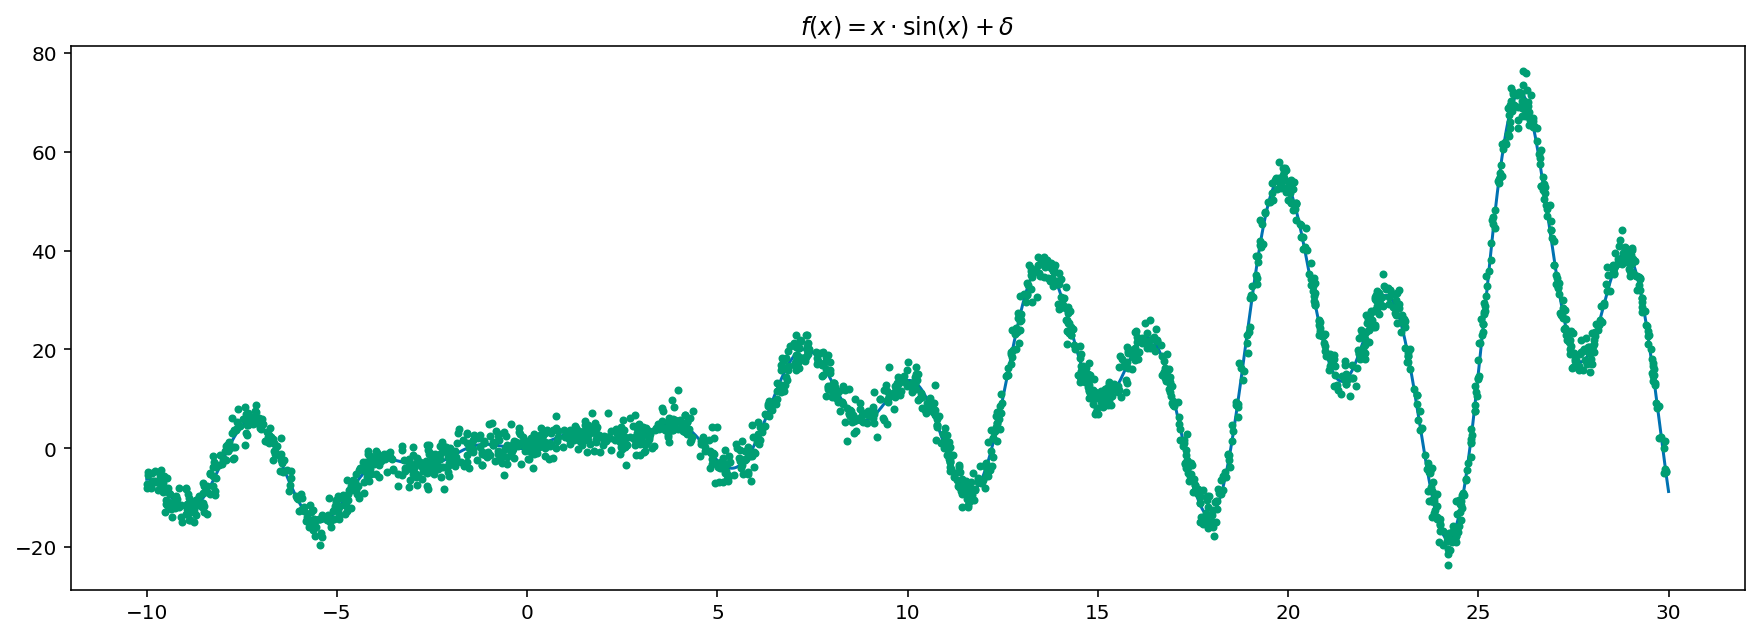

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
_ = ax.plot(X_test, y_test)
_ = ax.plot(X_train, y_train, marker=".", linestyle="none")
_ = ax.set_title("$f(x)=x\cdot\sin(x)+\delta$")

# Quantile Loss Example
Asymmetric penalization of errors, i.e. with the pinball loss function: <br>
$
\begin{align}
\label{eq:qLoss}
L_{\tau}(\xi)=\begin{cases}
\tau\xi & \text{if }\xi\geq0\\
(\tau-1)\xi & \text{if }\xi<0
\end{cases}
\end{align}
$
<br>
<br>
$\rightarrow$ Median loss (i.e. the 50% quantile) is symmetric:

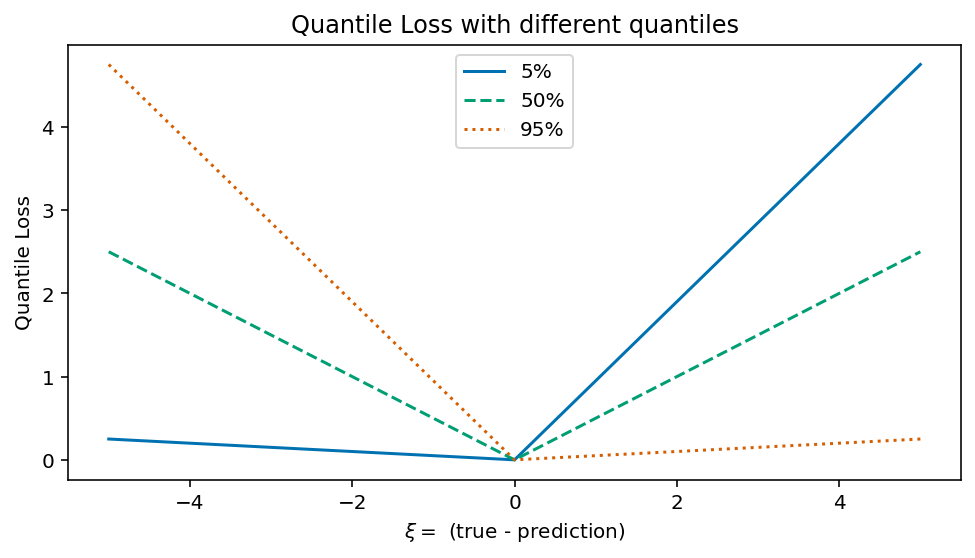

In [9]:
def quantile_loss(y_true, y_pred, quantile):
    residual = y_true - y_pred
    return np.maximum(quantile * residual, (quantile - 1) * residual)


xx = np.linspace(-5, 5, 101)

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.set_prop_cycle(PLT_CYCLER)
for q in QUANTILES:
    _ = ax.plot(xx, quantile_loss(0, xx, q), label="{:.0%}".format(q))
_ = ax.legend()
_ = ax.set_title("Quantile Loss with different quantiles")
_ = ax.set_xlabel(r"$\xi=\hspace{.1}$ (true - prediction)")
_ = ax.set_ylabel("Quantile Loss")

# Quantile Huber-, and LogCosh Loss Example
* Using only pinball loss could worsen the model performance, though. <br>
* One might implement some fancier loss functions in order to get some asymptotic pinball behavior but with a different loss function for smaller deviations: Huber & LogCosh Loss!

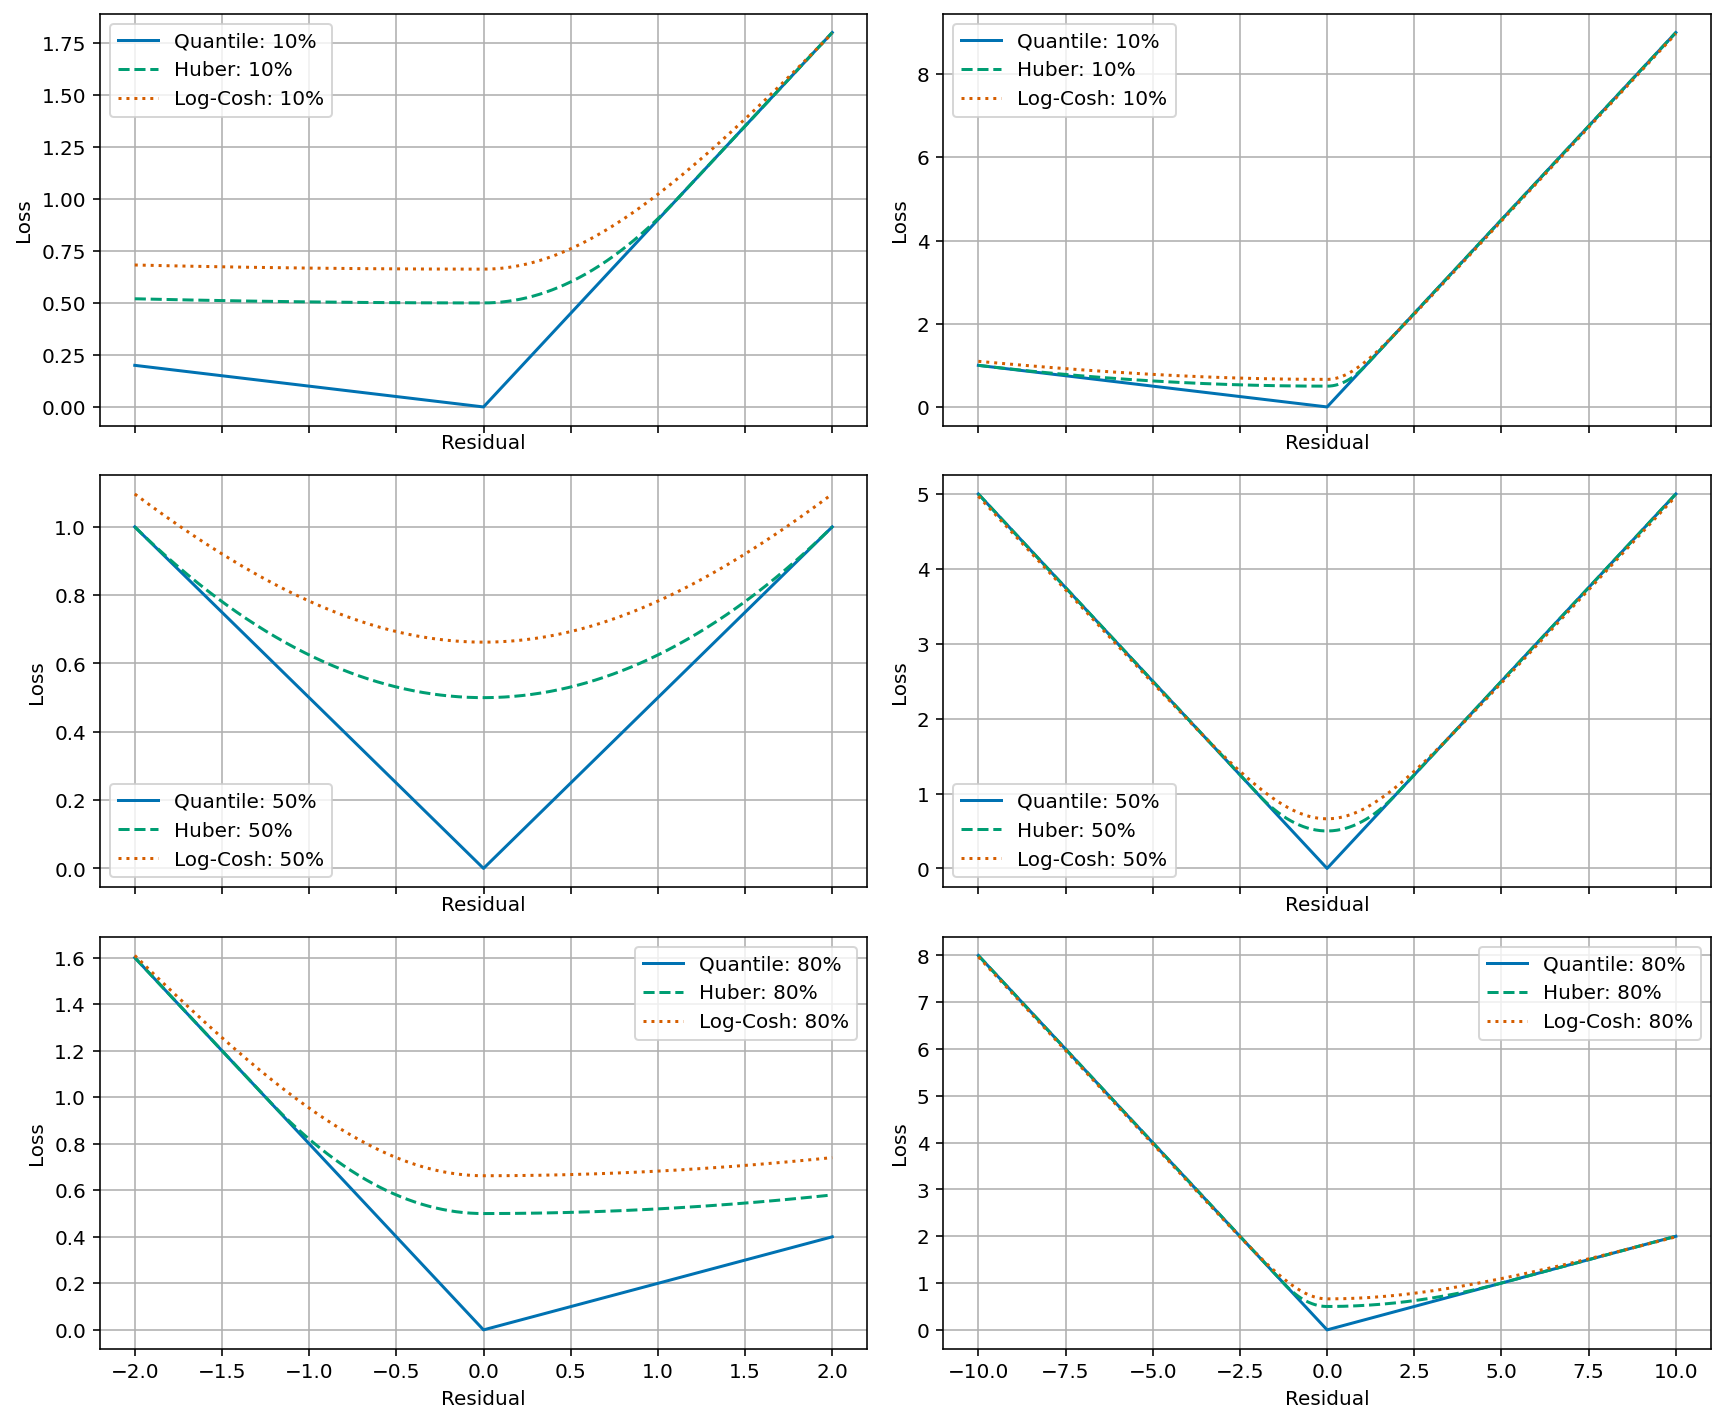

In [10]:
def huber_loss_quantile(y_true, y_pred, quantile, delta=1):
    """
    Calculates the Huber loss function 
    but scaled with the respective quantile as in the pinball loss.
    
    For aesthetic reasons the loss is offest by 0.5
    such that its asymptotic behavior equals the pinball loss.   
    """
    y_true = np.repeat(y_true, y_pred.shape[0])

    residual = y_true - y_pred
    quantile_residual = np.maximum(quantile * residual, (quantile - 1) * residual)

    loss = (
        np.where(
            np.abs(quantile_residual) < 1 / delta,
            0.5 * (quantile_residual ** 2),
            delta * np.abs(quantile_residual) - 0.5 * (delta ** 2),
        )
        + 0.5
    )

    return loss


def logcosh_loss_quantile(y_true, y_pred, quantile):
    """
    Calculates the ln(cosh(residual)) loss function 
    but scaled with the respective quantile as in the pinball loss.
    
    For aesthetic reasons the loss is offest by 0.5*ln(L) 
    where L is the limit of cosh(x) -> (e^2+e^-2)/2
    such that its asymptotic behavior equals the pinball loss.   
    """

    residual = y_true - y_pred

    offset = np.log((np.exp(1) ** 2 + np.exp(1) ** -2) / 2) / 2

    quantile_residual = np.maximum(quantile * residual, (quantile - 1) * residual)
    return np.log(np.cosh(quantile_residual)) + offset


xl = 2
xx_list = [np.linspace(-xl, xl, 1001), np.linspace(-xl * 5, xl * 5, 501)]

fig, axs = plt.subplots(3, 2, figsize=(12, 10), sharex="col")
axs = axs.flat


q_list = [0.1, 0.5, 0.8]

for idx, (q, xx) in enumerate(product(q_list, xx_list)):

    ax = axs[idx]
    ax.set_prop_cycle(PLT_CYCLER)

    _ = ax.plot(xx, quantile_loss(0, xx, q), label="Quantile: {:.0%}".format(q))
    _ = ax.plot(xx, huber_loss_quantile(0, xx, q), label="Huber: {:.0%}".format(q))
    _ = ax.plot(xx, logcosh_loss_quantile(0, xx, q), label="Log-Cosh: {:.0%}".format(q))

    _ = ax.grid()
    _ = ax.legend()
    _ = ax.set_xlabel("Residual")
    _ = ax.set_ylabel("Loss")

plt.tight_layout()

# Scikit-Learn GBR Quantile Regression
* Standard and robust implementation in sklearn

prediction of 5% quantile
prediction of 50% quantile
prediction of 95% quantile


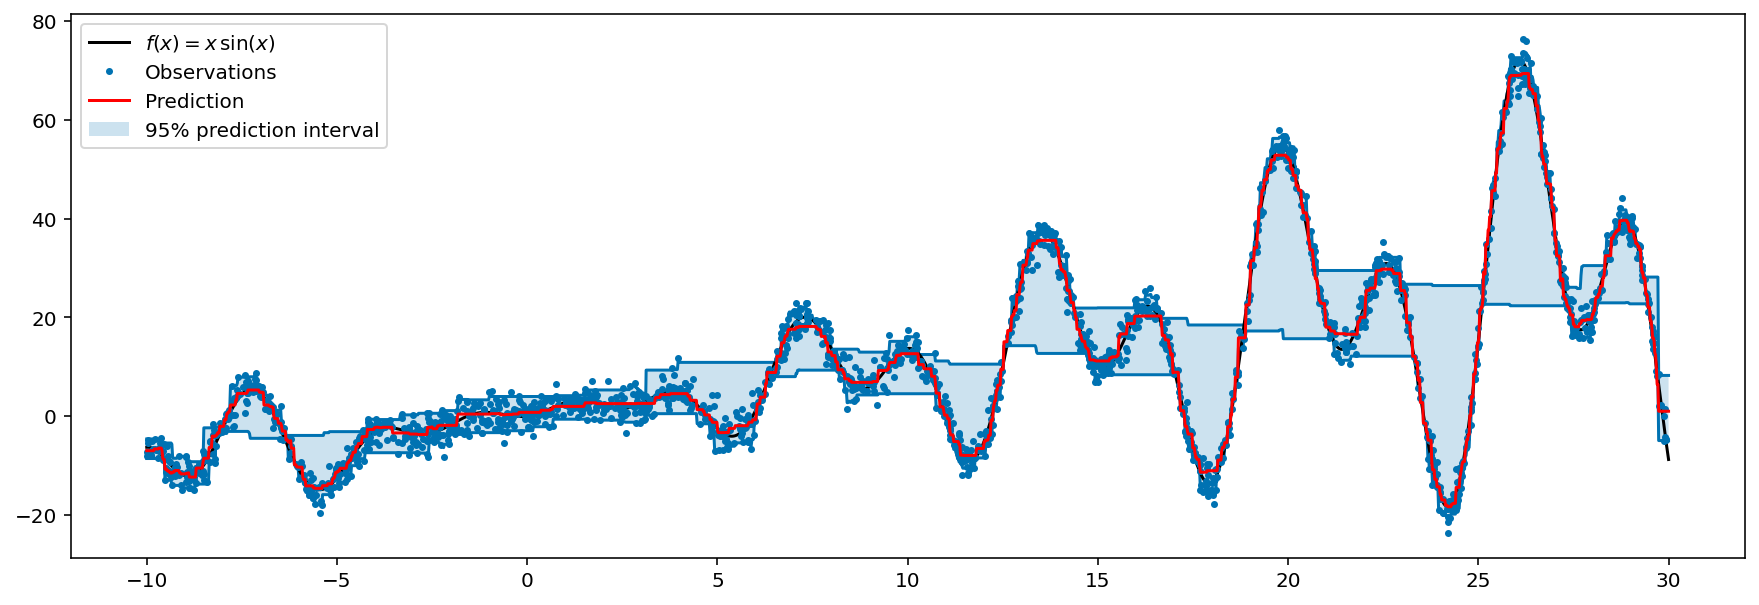

In [11]:
sklearn_kwargs = {
    "n_estimators": 300,
    "max_depth": 3,
    "learning_rate": 0.1,
    "min_samples_leaf": 9,
    "min_samples_split": 9,
}

skl_preds = list()
for q in QUANTILES:
    print("prediction of {:.0%} quantile".format(q))
    gbr = GradientBoostingRegressor(loss="quantile", alpha=q, **sklearn_kwargs)
    skl_preds.append(gbr.fit(X_train, y_train).predict(X_test))

_ = plot_result(alpha=ALPHA, preds=skl_preds, **data_kwargs)

Meh.

# Catboost Quantile Regression
* Catboost has a solid native solution for quantile regression

prediction of 5% quantile
prediction of 50% quantile
prediction of 95% quantile


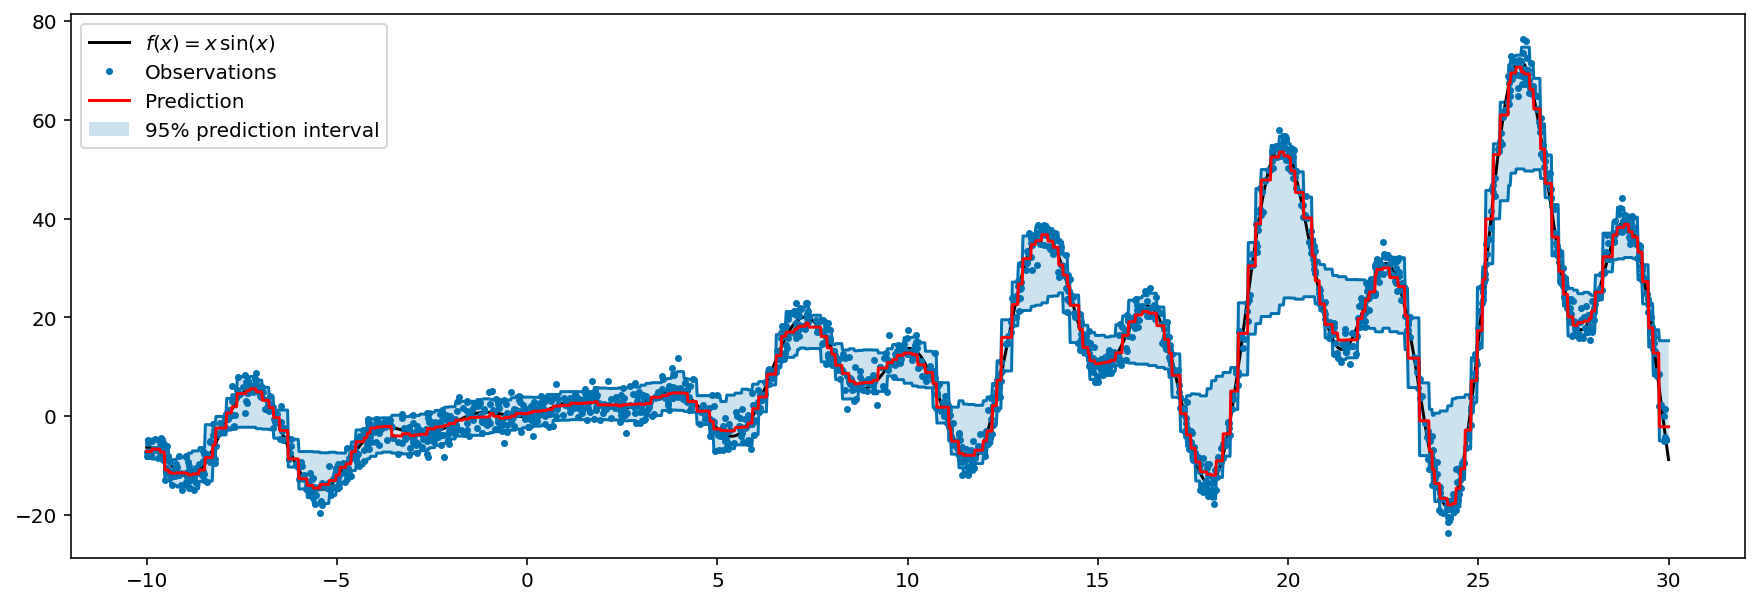

In [12]:
from catboost import CatBoostRegressor

cat_params = {"verbose": 0}

cat_preds = list()
for q in QUANTILES:
    print("prediction of {:.0%} quantile".format(q))
    gbr = CatBoostRegressor(loss_function=f"Quantile:alpha={q}", **cat_params)
    cat_preds.append(gbr.fit(X_train, y_train).predict(X_test))

_ = plot_result(alpha=ALPHA, preds=cat_preds, **data_kwargs)

# LightGBM Quantile Regression
* Again an easy implementation

prediction of 5% quantile
prediction of 50% quantile
prediction of 95% quantile


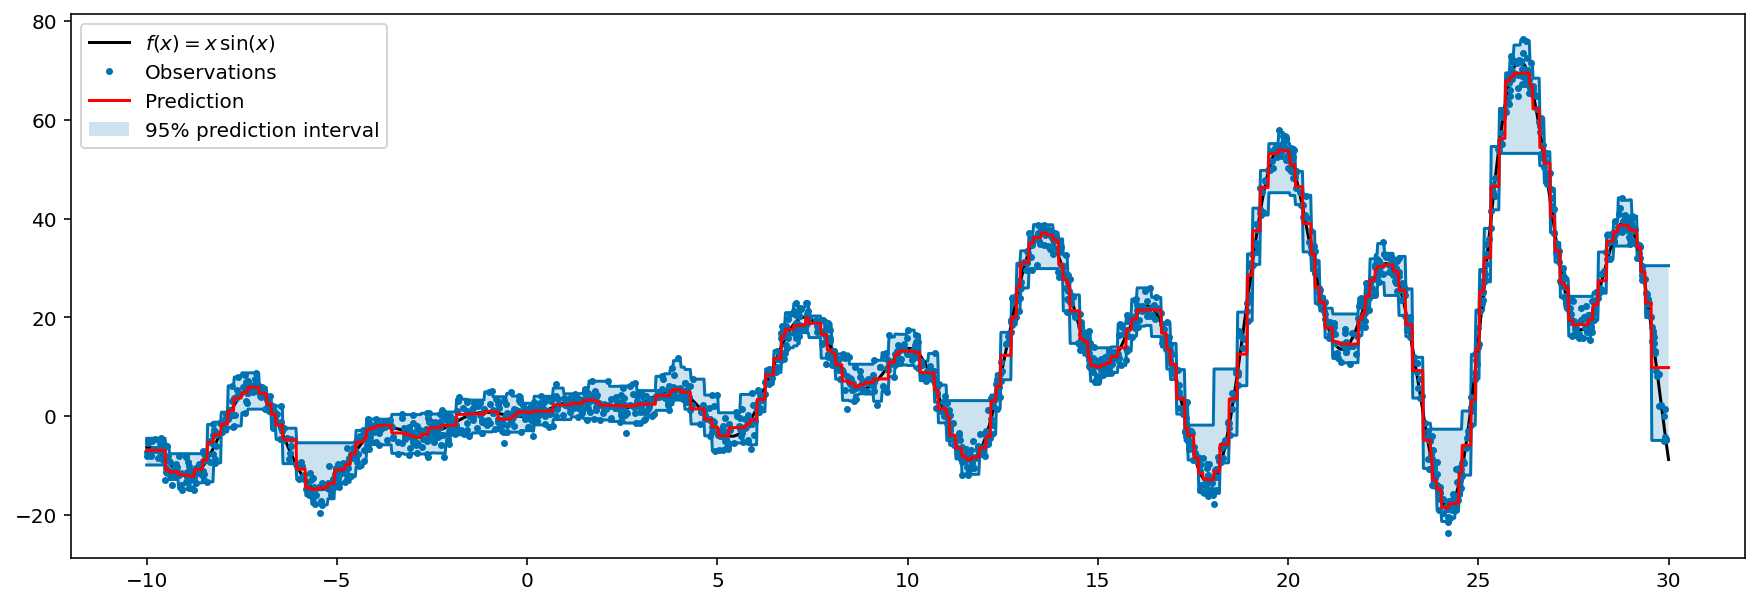

In [13]:
from lightgbm import LGBMRegressor

lgb_params = {"force_row_wise": True, "verbose": -1}

lgb_preds = list()
for q in QUANTILES:
    print("prediction of {:.0%} quantile".format(q))
    gbr = LGBMRegressor(objective="quantile", alpha=q, **lgb_params)
    lgb_preds.append(gbr.fit(X_train, y_train).predict(X_test))

_ = plot_result(alpha=ALPHA, preds=lgb_preds, **data_kwargs)

# XGBoost Quantile Regression 
* XGB doesn't have a native solution (yet), requires customized loss function instead.
* Proposed solution from https://towardsdatascience.com/regression-prediction-intervals-with-xgboost-428e0a018b seems to be quite unstable


prediction of 5% quantile
prediction of 50% quantile
prediction of 95% quantile


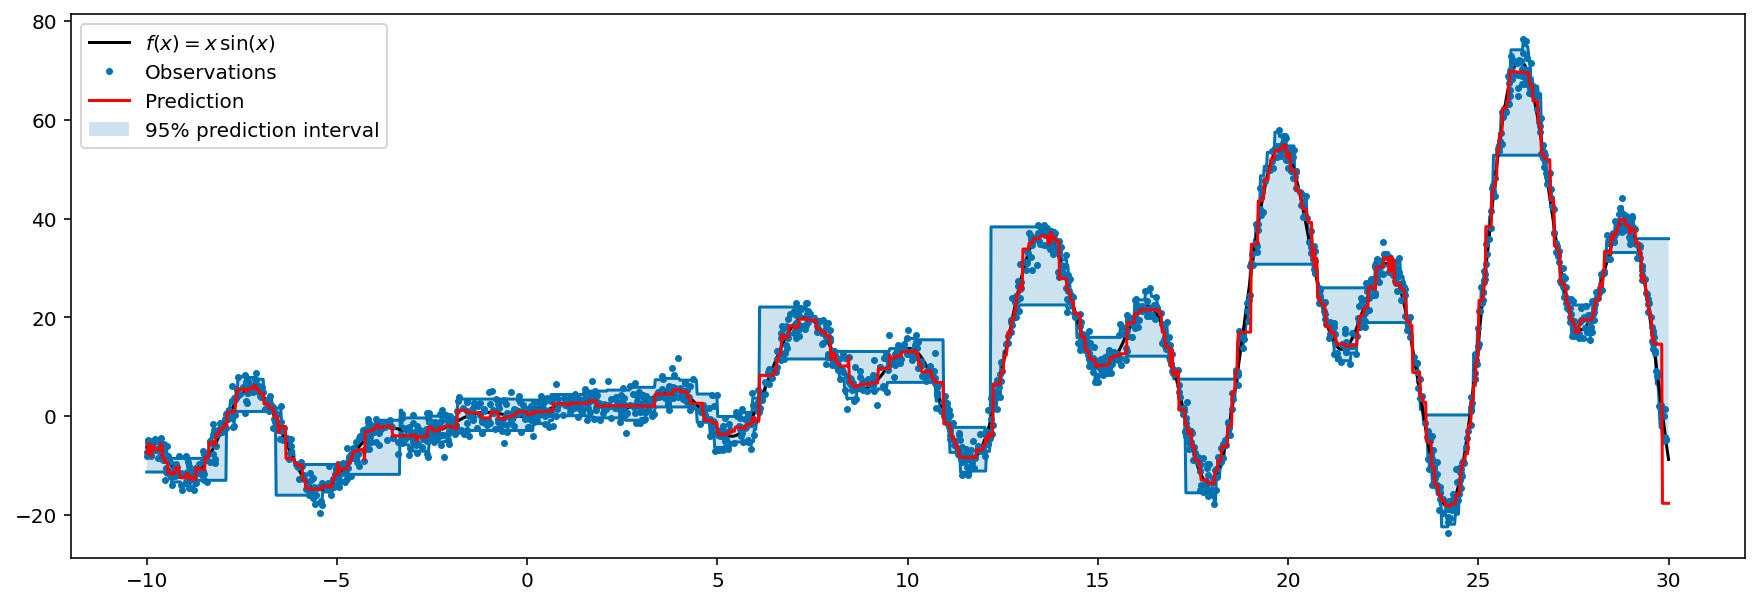

In [14]:
from functools import partial
from xgboost import XGBRegressor

xgb_params = {
    "n_estimators": 200,
    "max_depth": 3,
    "random_state": 0,
    "verbosity": 0,
}


def qloss(y_true, y_pred, tau):
    x = y_true - y_pred
    grad = (
        (x < (tau - 1)) * (1 - tau)
        - ((x >= (tau - 1)) & (x < tau)) * x
        - tau * (x > tau)
    )
    hess = (x >= (tau - 1)) & (x < tau)
    return grad, hess


xgb_preds = list()
for q in QUANTILES:
    print("prediction of {:.0%} quantile".format(q))
    ql = partial(qloss, tau=q)
    gbr = XGBRegressor(objective=ql, **xgb_params)
    xgb_preds.append(gbr.fit(X_train, y_train).predict(X_test))


_ = plot_result(alpha=ALPHA, preds=xgb_preds, **data_kwargs)